In [48]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import altair as alt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA as SklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.impute import SimpleImputer
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from sklearn.preprocessing import normalize
from datetime import datetime

import project_fuctions as functions

try:
    from scipy import sparse
except Exception:
    sparse = None

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

### Data Loading

In [49]:
dataset = "data/merge_dataset_cleaned.csv"
print(f"Caricamento di '{dataset}'...")

try:
    # Azione di Caricamento
    df = pd.read_csv(dataset)

    print(f"\nSUCCESSO: DataFrame caricato con successo.")
    print(f"Shape: {df.shape}")
    print("Il DataFrame è ora pronto per la 'Data Transformation'.")

except FileNotFoundError:
    print(f"\nERRORE: File non trovato.")
    print(f"Assicurati che il file '{dataset}' esista e che il percorso sia corretto.")
except Exception as e:
    print(f"\nERRORE: Si è verificato un errore durante il caricamento del file.")
    print(f"Dettagli errore: {e}")

# Ispezioniamo rapidamente l'intestazione e i tipi di dati per confermare
if 'df' in locals():
    print("\n--- Ispezione Post-Caricamento ---")
    print("Prime 5 righe:")
    display(df.head())
    print("\nTipi di dati (Dtypes):")
    df.info()

Caricamento di 'data/merge_dataset_cleaned.csv'...

SUCCESSO: DataFrame caricato con successo.
Shape: (10935, 50)
Il DataFrame è ora pronto per la 'Data Transformation'.

--- Ispezione Post-Caricamento ---
Prime 5 righe:


id    id_artist                 title language  swear_IT  swear_EN  \
0  TR575166  ART17812958               A me mi       it         0         0   
1  TR955940  ART40229749              Insomnia       it         1         0   
2  TR889717  ART86549066            #Rossoneri       it         0         0   
3  TR754452  ART61734477                   #SI       it         2        15   
4  TR820569  ART71969350  O’ Vient (Unplugged)       it         3         0   

                  swear_IT_words     swear_EN_words    year  month  ...  \
0                             []                 []  2020.0    1.0  ...   
1                   ['bastardi']                 []  2008.0   10.0  ...   
2                             []                 []  2015.0    9.0  ...   
3           ['fottere', 'troia']  ['bitch', 'shit']  2022.0    3.0  ...   
4  ['cazzo', 'merda', 'puttana']                 []     NaN    NaN  ...   

    latitude   longitude  popularity_missing_flag  n_tokens  n_sentences  \
0  45.464194    9.189635                        0       521           69   
1   1.290270  103.851959                        0       680          108   
2  45.613963    9.370060                        0       321           61   
3  45.634859   11.406354                        0       458           68   
4  40.996545   15.140569                        0       577           82   

   lexical_density  tokens_per_sent  char_per_tok  predicted_language  \
0         0.416507         7.550725      3.838772                 NaN   
1         0.430882         6.296296      4.044118                 NaN   
2         0.336449         5.262295      3.548287                 NaN   
3         0.465066         6.735294      3.781659                 NaN   
4         0.459272         7.036585      3.935875                 NaN   

   album_release_date  
0          2025-06-17  
1          2018-03-28  
2          2015-09-11  
3          2022-03-25  
4          2017-06-16  

[5 rows x 50 columns]


Tipi di dati (Dtypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       10935 non-null  object 
 1   id_artist                10935 non-null  object 
 2   title                    10935 non-null  object 
 3   language                 10935 non-null  object 
 4   swear_IT                 10935 non-null  int64  
 5   swear_EN                 10935 non-null  int64  
 6   swear_IT_words           10935 non-null  object 
 7   swear_EN_words           10935 non-null  object 
 8   year                     10546 non-null  object 
 9   month                    9790 non-null   float64
 10  day                      9673 non-null   float64
 11  bpm                      10873 non-null  float64
 12  centroid                 10873 non-null  float64
 13  rolloff                  10873 non-null  float64
 14

In [50]:
import dtale

d = dtale.show(df, notebook=True)


### Data Distribution

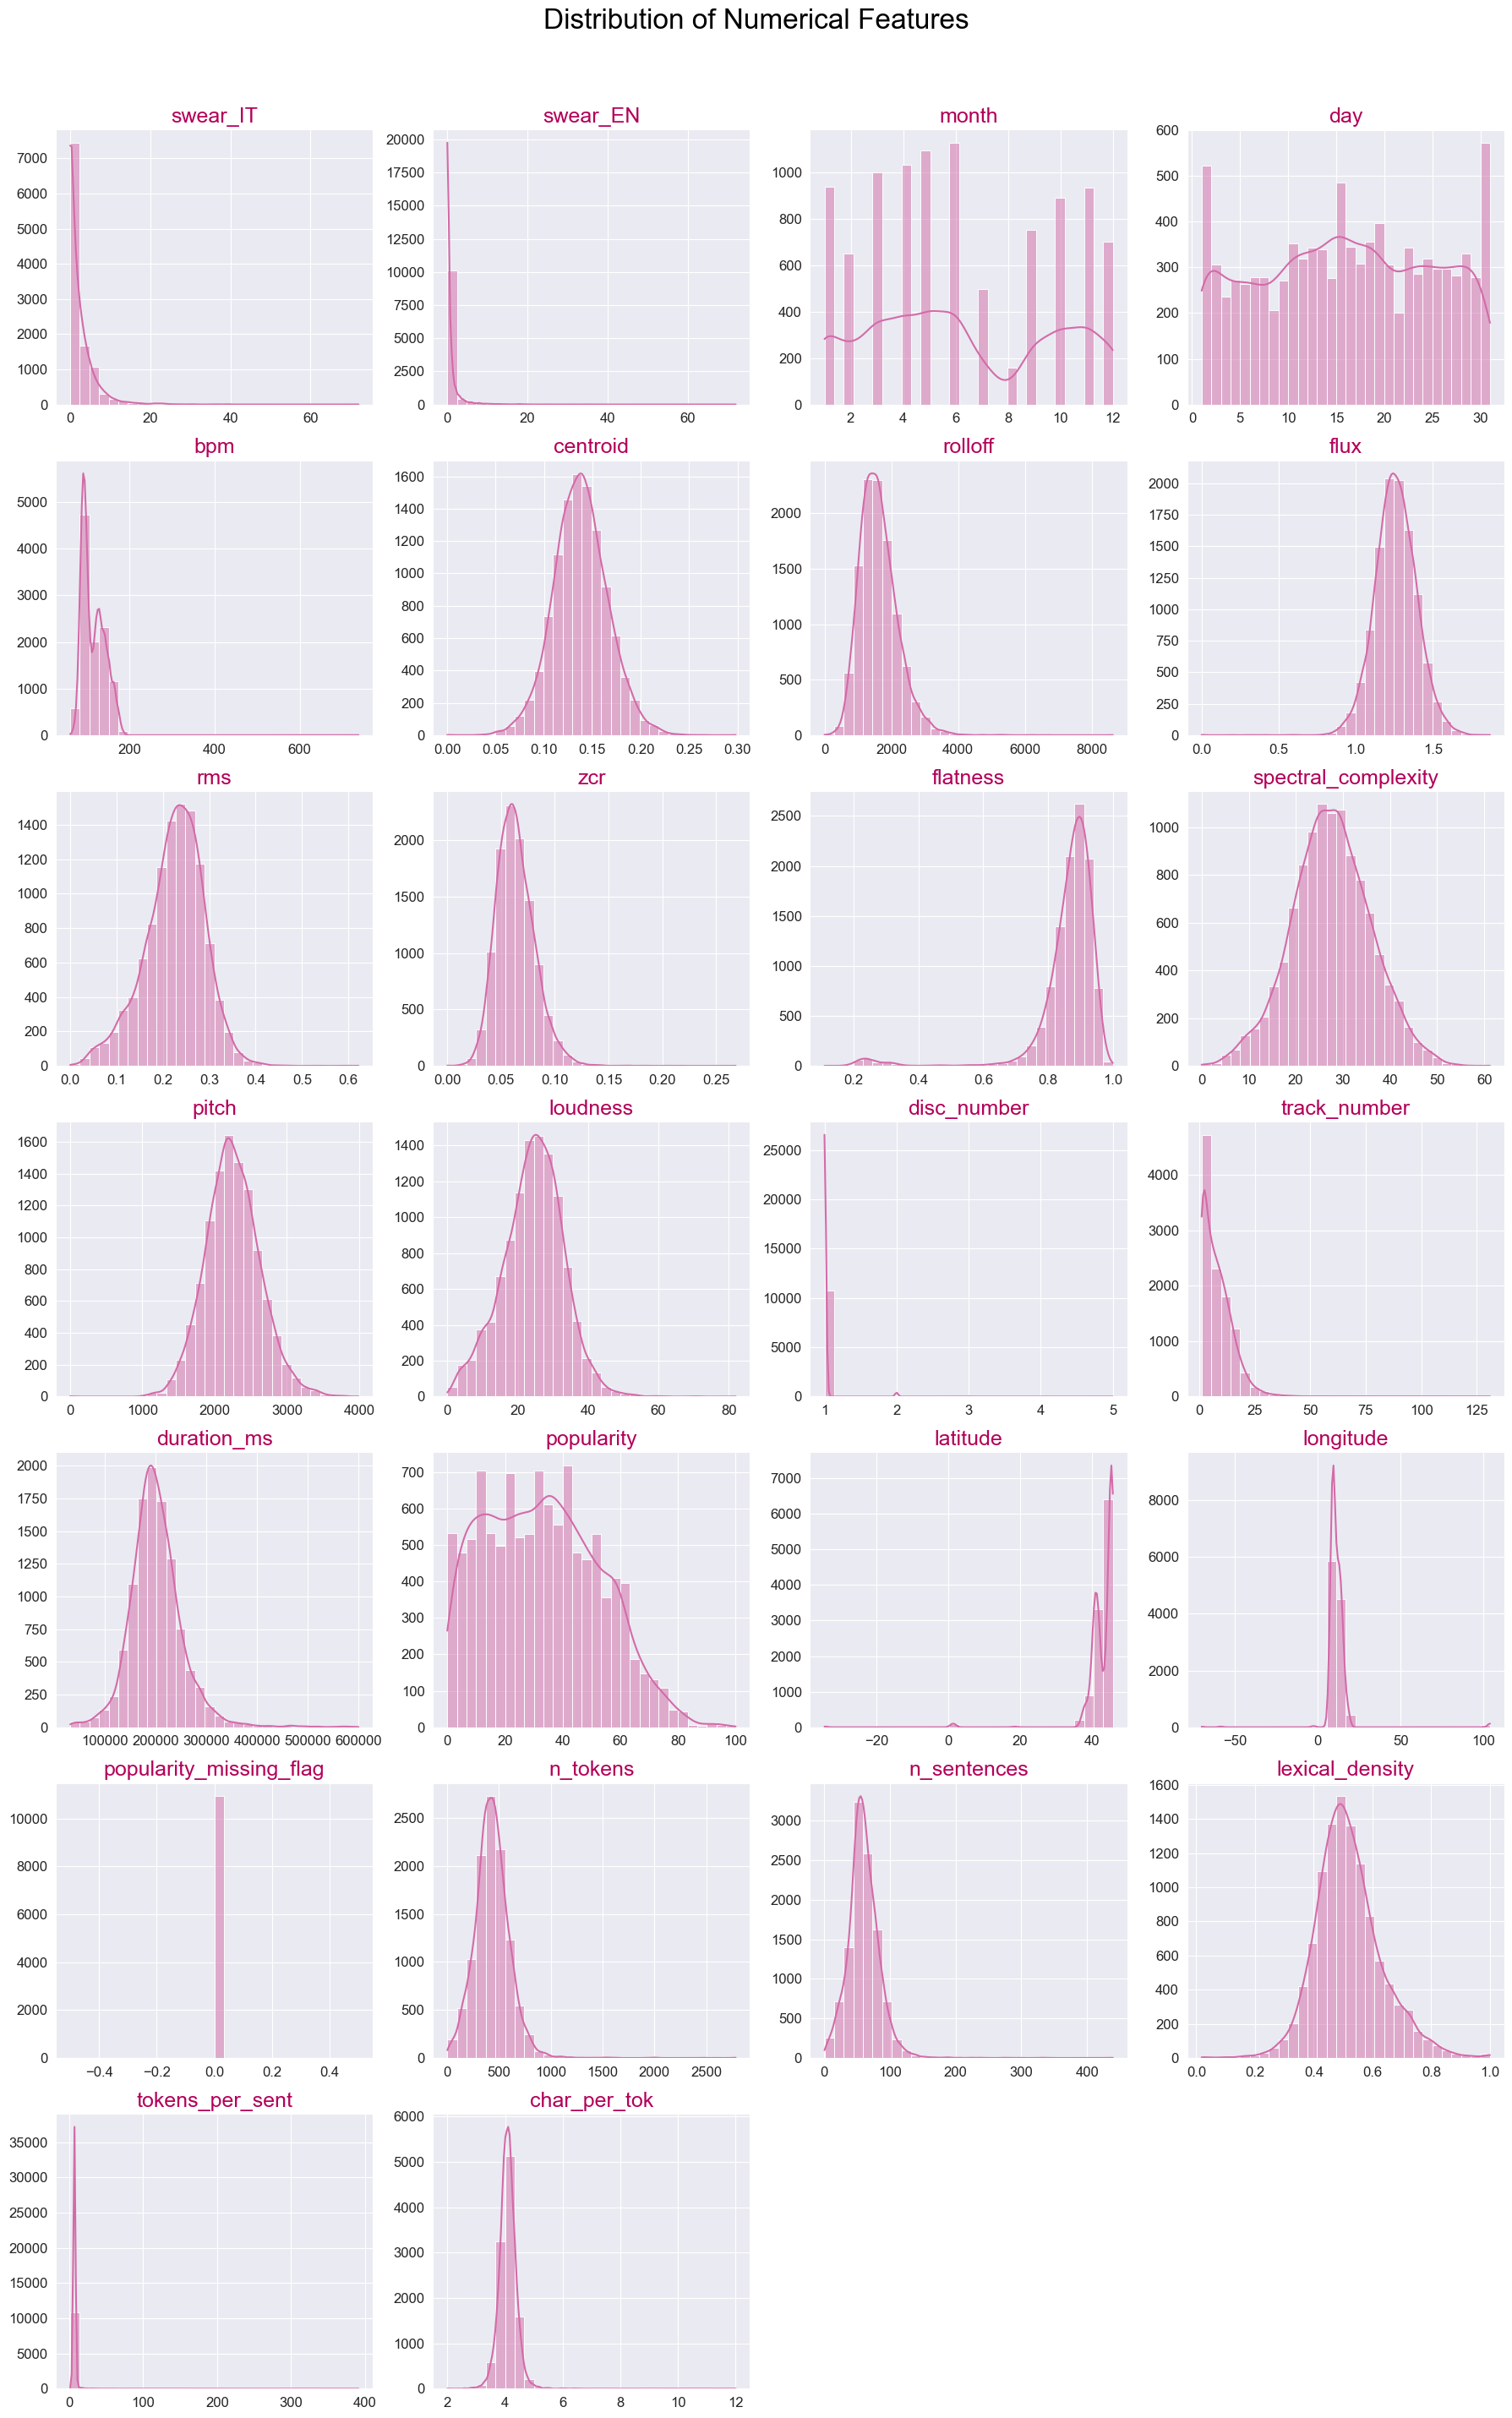

In [51]:
# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# --- Summary statistics table ---
display(df[num_cols].describe().T.style.background_gradient(cmap='RdPu'))

# --- Histograms for each numeric column ---
n_cols = 4
n_rows = -(-len(num_cols) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, color="#d36ba8", ax=axes[i])
    axes[i].set_title(col, fontsize=18, color="#b30059")   # larger title font
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', labelsize=12)          # larger tick labels

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Numerical Features", fontsize=24, color="#000000", y=1.02)  # larger main title
plt.tight_layout()
plt.show()


In [52]:
# Calculate basic statistics (mean and median)
statistics = df[num_cols].describe().T

# Calculate skewness
skews = df[num_cols].skew()

skew_analysis = pd.DataFrame({
    'mean': statistics['mean'],
    'median': statistics['50%'],
    'skewness_value': skews
})

# Define a function to classify skewness
# These are standard thresholds used in statistics:
# > +0.5 = Positive Skew (Right-tailed)
# < -0.5 = Negative Skew (Left-tailed)
# Between -0.5 and +0.5 = Substantially Symmetric
def classify_skew(skew_value):
    if skew_value > 0.5:
        return "Positive (Right Skew)"
    elif skew_value < -0.5:
        return "Negative (Left Skew)"
    else:
        return "Symmetric"

skew_analysis['skew_type'] = skew_analysis['skewness_value'].apply(classify_skew)

print("Skewness Analysis of Numerical Features")

display(skew_analysis.sort_values(by='skewness_value', ascending=False))

Skewness Analysis of Numerical Features


mean         median  skewness_value  \
tokens_per_sent               7.466343       7.259259       47.623930   
disc_number                   1.016552       1.000000       10.190249   
swear_EN                      0.722085       0.000000       10.102553   
longitude                    11.682747       9.691233        6.075364   
track_number                  8.678006       7.000000        5.598120   
swear_IT                      2.385002       1.000000        4.390369   
char_per_tok                  4.091262       4.089514        1.842888   
n_sentences                  60.528761      59.000000        1.696915   
bpm                         114.217822     107.020000        1.652572   
n_tokens                    434.619936     428.000000        1.489182   
duration_ms              201072.098367  196617.000000        1.141997   
rolloff                    1620.428304    1554.609200        1.075596   
zcr                           0.063457       0.061800        0.818775   
lexical_density               0.519368       0.507576        0.515356   
popularity                   32.790764      32.000000        0.292276   
month                         6.211134       6.000000        0.186908   
pitch                      2252.663205    2238.696300        0.177416   
centroid                      0.137795       0.137400        0.088547   
spectral_complexity          27.531599      27.442500        0.010918   
popularity_missing_flag       0.000000       0.000000        0.000000   
day                          15.821152      16.000000       -0.030248   
loudness                     24.346222      24.774400       -0.071642   
flux                          1.259499       1.257300       -0.180332   
rms                           0.224916       0.230300       -0.357631   
flatness                      0.860384       0.882300       -4.111216   
latitude                     42.990922      44.493820       -8.372019   

                                     skew_type  
tokens_per_sent          Positive (Right Skew)  
disc_number              Positive (Right Skew)  
swear_EN                 Positive (Right Skew)  
longitude                Positive (Right Skew)  
track_number             Positive (Right Skew)  
swear_IT                 Positive (Right Skew)  
char_per_tok             Positive (Right Skew)  
n_sentences              Positive (Right Skew)  
bpm                      Positive (Right Skew)  
n_tokens                 Positive (Right Skew)  
duration_ms              Positive (Right Skew)  
rolloff                  Positive (Right Skew)  
zcr                      Positive (Right Skew)  
lexical_density          Positive (Right Skew)  
popularity                           Symmetric  
month                                Symmetric  
pitch                                Symmetric  
centroid                             Symmetric  
spectral_complexity                  Symmetric  
popularity_missing_flag              Symmetric  
day                                  Symmetric  
loudness                             Symmetric  
flux                                 Symmetric  
rms                                  Symmetric  
flatness                  Negative (Left Skew)  
latitude                  Negative (Left Skew)

### Data Transformation

Based on our `Data Understanding` analysis, we are intentionally excluding `month`, `day`, `latitude`, `longitude`, `disc_number`, `track_number`, and `popularity_missing_flag` from the transformation and scaling steps.

These features are not suitable for our distance-based clustering (Task 2) for the following reasons:

* **Cyclical/Ordinal Features (`month`, `day`, `disc_number`, `track_number`):** These are not continuous quantitative values. Treating them as linear numbers is methodologically flawed for K-Means, as it would incorrectly interpret January (1) and December (12) as "far" apart. Their skewness values are statistical artifacts, not properties to be "fixed".
* **Spatial Features (`latitude`, `longitude`):** These are coordinates describing the *artist's origin*, not the *song's content*. They are considered noise for clustering by "musical style, lyrical content, [and] production patterns". Our project notes suggest using them only for visualization.
* **Binary Flag (`popularity_missing_flag`):** This is a 0/1 indicator. Scaling it is unnecessary and would remove its clear, interpretable meaning.


In [53]:
# Definizione delle Liste di Feature
features_positive_skew = [
    'tokens_per_sent', 'duration_ms',
    'swear_EN', 'swear_IT', 'char_per_tok',
    'n_sentences', 'bpm', 'n_tokens', 'rolloff',
    'zcr', 'lexical_density'
]

features_negative_skew = ['flatness']

features_symmetric = [
    'popularity', 'pitch', 'centroid',
    'spectral_complexity', 'loudness', 'flux', 'rms'
]

# Filtra solo per le colonne che esistono
features_positive_skew = [col for col in features_positive_skew if col in df.columns]
features_negative_skew = [col for col in features_negative_skew if col in df.columns]
features_symmetric = [col for col in features_symmetric if col in df.columns]

# Applica la Trasformazione Logaritmica (per Asimmetria Positiva)
print(f"Applying log(x+1) transform to {len(features_positive_skew)} positively skewed features...")
for col in features_positive_skew:
    new_col_name = f"log_{col}"
    df[new_col_name] = np.log1p(df[col])

# Applica la Trasformazione "Riflessa" (per Asimmetria Negativa)
print(f"Applying reflected log(x+1) transform to {len(features_negative_skew)} negatively skewed features...")
for col in features_negative_skew:
    new_col_name = f"log_{col}_reflected"
    # 1. Rifletti i dati: (Max + 1) - x
    reflected_data = df[col].max() + 1 - df[col]
    # 2. Applica il log
    df[new_col_name] = np.log1p(reflected_data)

new_positive_cols = [f"log_{col}" for col in features_positive_skew if f"log_{col}" in df.columns]
new_negative_cols = [f"log_{col}_reflected" for col in features_negative_skew if f"log_{col}_reflected" in df.columns]
symmetric_cols = [col for col in features_symmetric if col in df.columns]

# Combina tutte le feature che ora dovrebbero essere (quasi) simmetriche
features_to_verify = new_positive_cols + new_negative_cols + symmetric_cols

print(f"Verifying {len(features_to_verify)} transformed/symmetric features...")

Applying log(x+1) transform to 11 positively skewed features...
Applying reflected log(x+1) transform to 1 negatively skewed features...
Verifying 19 transformed/symmetric features...


#### Check New Distribution

In [54]:
print("Skewness Analysis (AFTER Log Transform)")

statistics = df[features_to_verify].describe().T
skews = df[features_to_verify].skew()

skew_analysis_after = pd.DataFrame({
    'mean': statistics['mean'],
    'median': statistics['50%'],
    'skewness_value': skews
})

def classify_skew(skew_value):
    if skew_value > 0.5:
        return "Positive (Right Skew)"
    elif skew_value < -0.5:
        return "Negative (Left Skew)"
    else:
        return "Symmetric"

skew_analysis_after['skew_type'] = skew_analysis_after['skewness_value'].apply(classify_skew)

print("Risultati della nuova analisi di asimmetria:")
display(skew_analysis_after.sort_values(by='skewness_value', ascending=False))


Skewness Analysis (AFTER Log Transform)
Risultati della nuova analisi di asimmetria:


mean       median  skewness_value  \
log_flatness_reflected     0.759497     0.750331        3.737512   
log_tokens_per_sent        2.104232     2.111335        2.581669   
log_swear_EN               0.276283     0.000000        2.437189   
log_zcr                    0.061383     0.059966        0.710230   
log_swear_IT               0.855412     0.693147        0.571422   
log_bpm                    4.721537     4.682316        0.301584   
popularity                32.790764    32.000000        0.292276   
pitch                   2252.663205  2238.696300        0.177416   
log_char_per_tok           1.625808     1.627182        0.168964   
log_lexical_density        0.415494     0.410503        0.162172   
centroid                   0.137795     0.137400        0.088547   
spectral_complexity       27.531599    27.442500        0.010918   
loudness                  24.346222    24.774400       -0.071642   
flux                       1.259499     1.257300       -0.180332   
rms                        0.224916     0.230300       -0.357631   
log_duration_ms           12.175937    12.189018       -1.075001   
log_rolloff                7.329287     7.349623       -1.319655   
log_n_sentences            4.028971     4.094345       -1.813194   
log_n_tokens               5.981522     6.061457       -2.224741   

                                    skew_type  
log_flatness_reflected  Positive (Right Skew)  
log_tokens_per_sent     Positive (Right Skew)  
log_swear_EN            Positive (Right Skew)  
log_zcr                 Positive (Right Skew)  
log_swear_IT            Positive (Right Skew)  
log_bpm                             Symmetric  
popularity                          Symmetric  
pitch                               Symmetric  
log_char_per_tok                    Symmetric  
log_lexical_density                 Symmetric  
centroid                            Symmetric  
spectral_complexity                 Symmetric  
loudness                            Symmetric  
flux                                Symmetric  
rms                                 Symmetric  
log_duration_ms          Negative (Left Skew)  
log_rolloff              Negative (Left Skew)  
log_n_sentences          Negative (Left Skew)  
log_n_tokens             Negative (Left Skew)

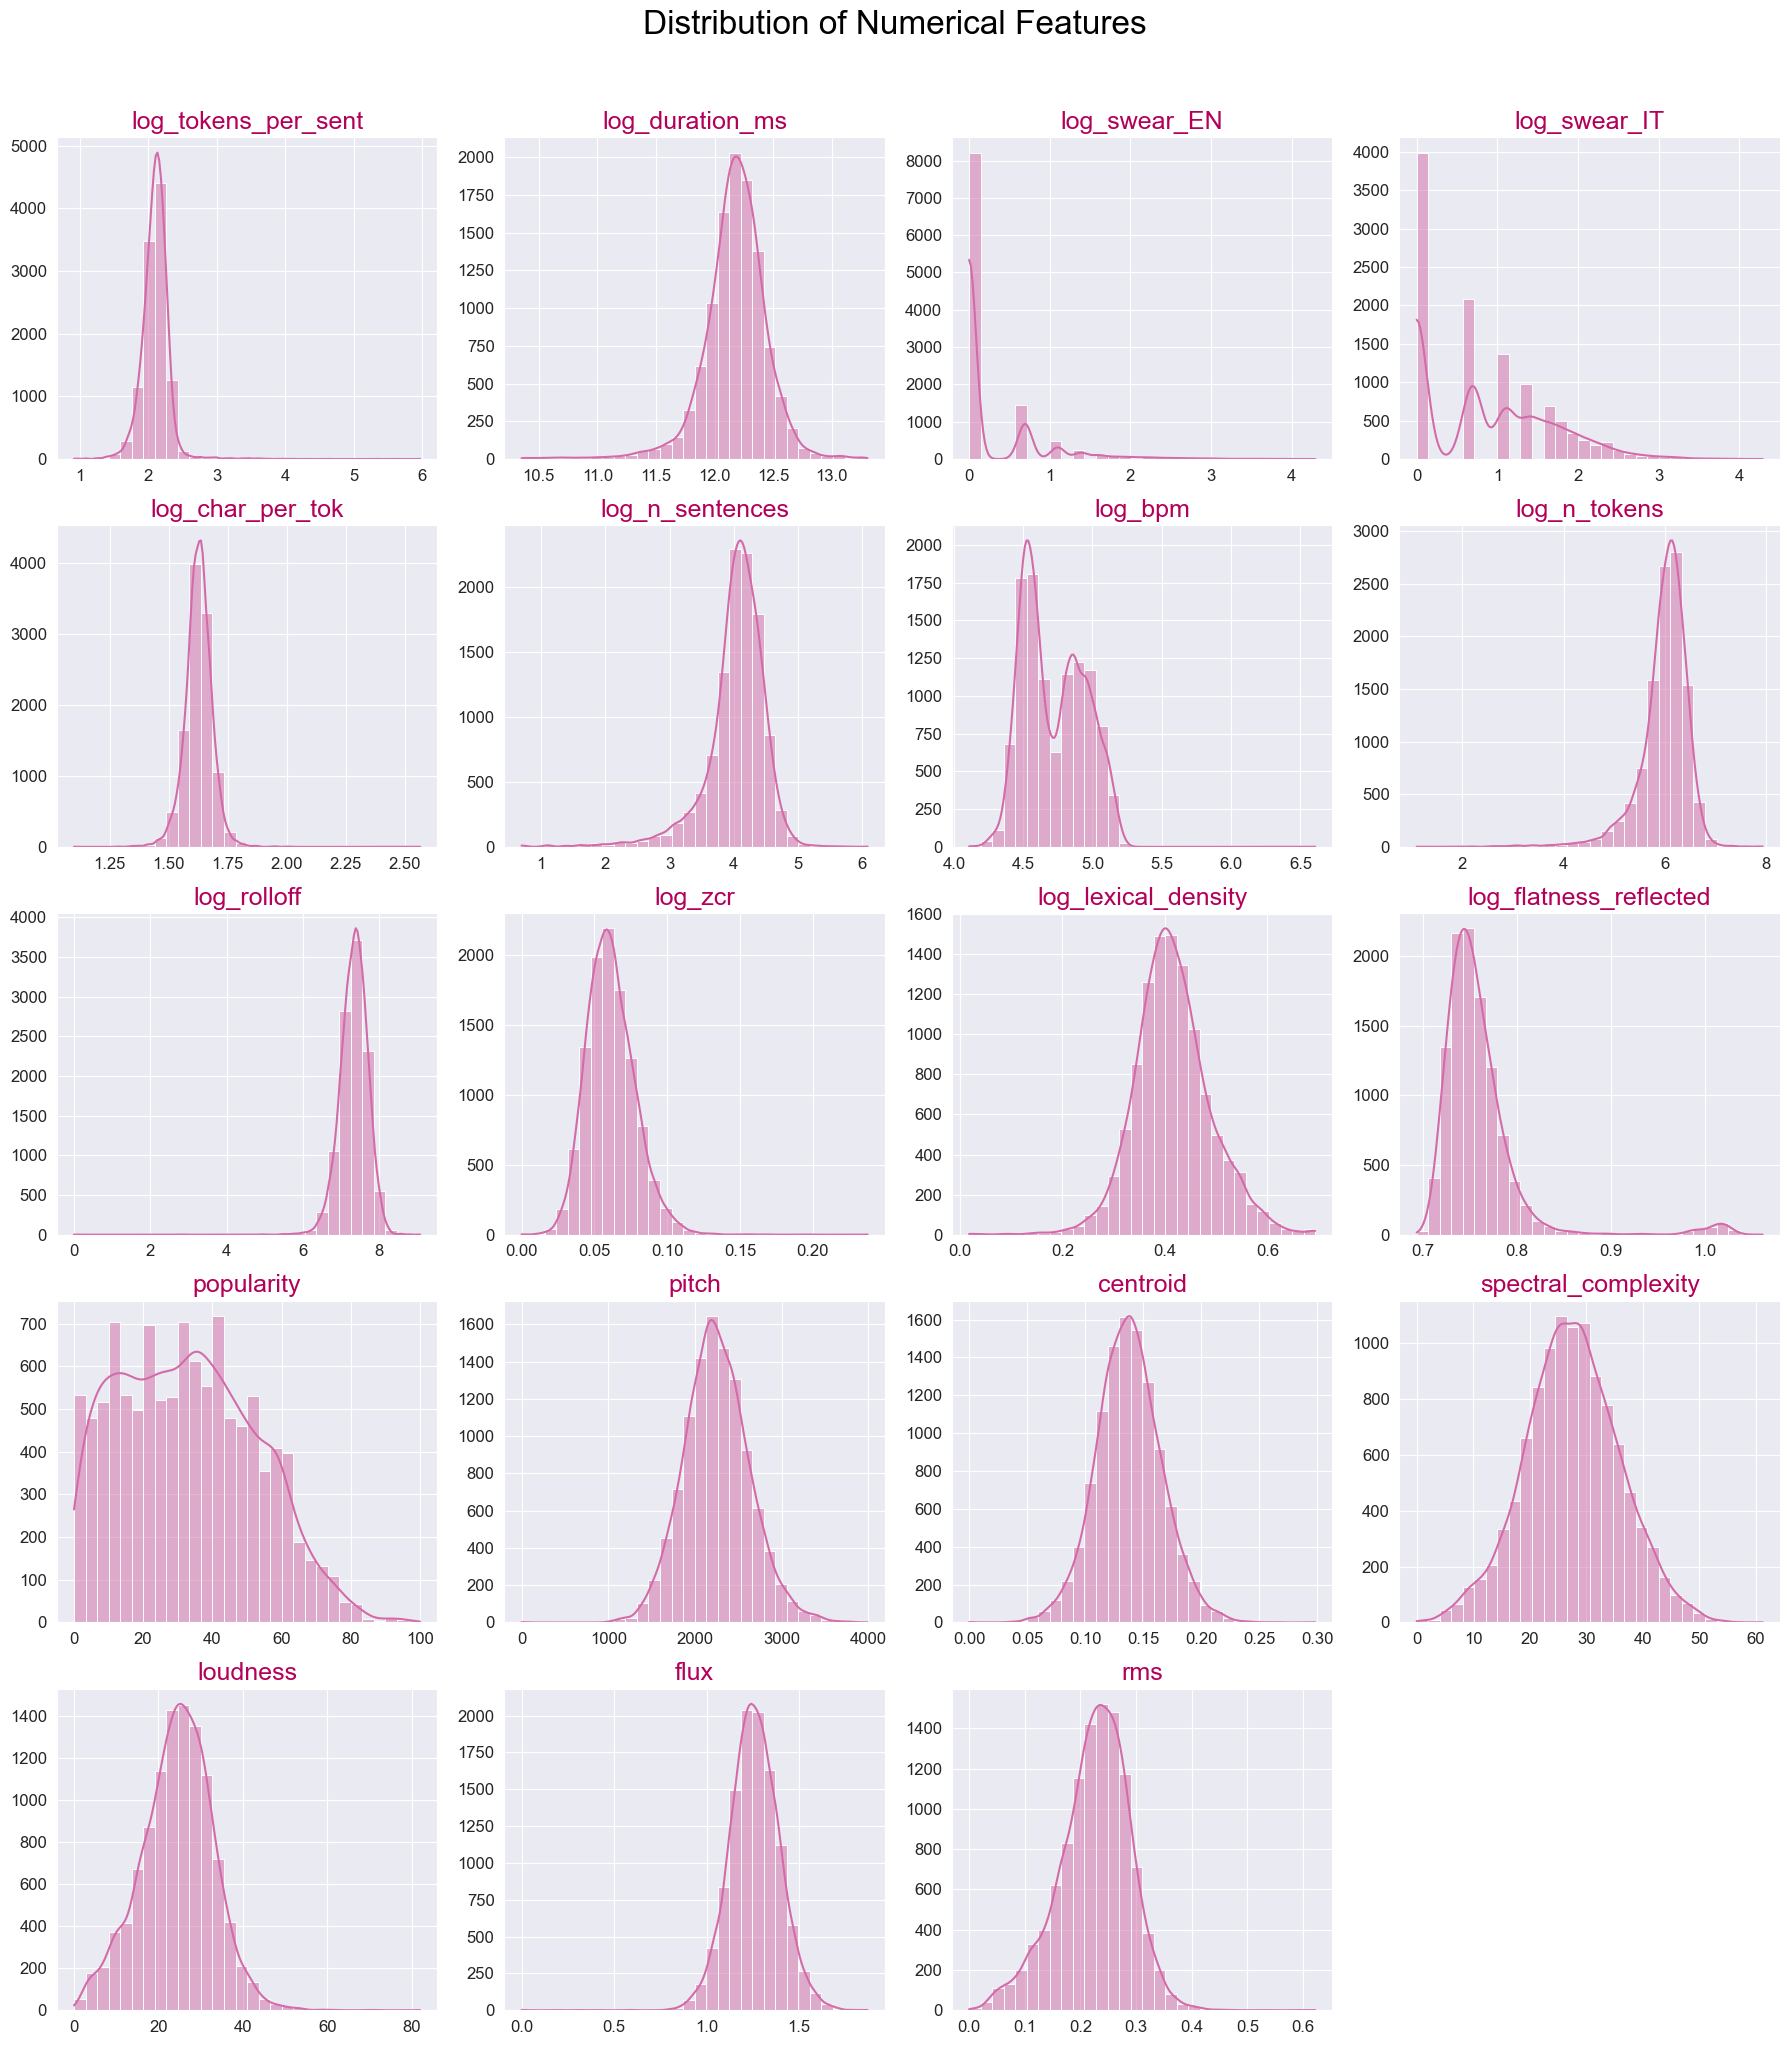

In [55]:
display(df[features_to_verify].describe().T.style.background_gradient(cmap='RdPu'))

#  Histograms for each numeric column
n_cols = 4
n_rows = -(-len(features_to_verify) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_verify):
    sns.histplot(df[col].dropna(), bins=30, kde=True, color="#d36ba8", ax=axes[i])
    axes[i].set_title(col, fontsize=18, color="#b30059")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', labelsize=12)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Numerical Features", fontsize=24, color="#000000", y=1.02)
plt.tight_layout()
plt.show()


#### Normalizzation

In [56]:
print(f"Shape prima della normalizzazione: {df.shape}")

# Aggiungiamo anche la colonna 'popularity_missing_flag' (che è 0 o 1)
features_symmetric.append('popularity_missing_flag')

# Creazione della Lista Finale di Tutte le Feature da Scalare
# 1. Le feature simmetriche originali
features_to_scale = [col for col in features_symmetric if col in df.columns]
# 2. Le *nuove* feature log-trasformate (positive)
features_to_scale += [f"log_{col}" for col in features_positive_skew if f"log_{col}" in df.columns]
# 3. Le *nuove* feature log-trasformate (negative)
features_to_scale += [f"log_{col}_reflected" for col in features_negative_skew if f"log_{col}_reflected" in df.columns]

print(f"Trovate {len(features_to_scale)} feature numeriche totali da normalizzare.")

scaler = StandardScaler()

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\n--- Verifica: Statistiche DOPO la Normalizzazione ---")
print("Tutte le feature dovrebbero ora avere media (mean) ~0.0 e deviazione standard (std) ~1.0")
display(df[features_to_scale].describe().T)


Shape prima della normalizzazione: (10935, 62)
Trovate 20 feature numeriche totali da normalizzare.

--- Verifica: Statistiche DOPO la Normalizzazione ---
Tutte le feature dovrebbero ora avere media (mean) ~0.0 e deviazione standard (std) ~1.0


count          mean       std        min       25%  \
popularity               10935.0 -5.718131e-17  1.000046  -1.664439 -0.852289   
pitch                    10873.0  6.338880e-16  1.000046  -5.965325 -0.663900   
centroid                 10873.0  4.234633e-16  1.000046  -4.923336 -0.653674   
spectral_complexity      10873.0 -3.875212e-16  1.000046  -3.285747 -0.657612   
loudness                 10873.0  1.725221e-16  1.000046  -2.834012 -0.624164   
flux                     10873.0  7.449818e-16  1.000046  -9.284988 -0.638405   
rms                      10873.0 -4.130075e-16  1.000046  -3.513053 -0.581293   
popularity_missing_flag  10935.0  0.000000e+00  0.000000   0.000000  0.000000   
log_tokens_per_sent      10935.0  1.406140e-15  1.000046  -5.668152 -0.486788   
log_duration_ms          10898.0 -3.202593e-15  1.000046  -6.597234 -0.470912   
log_swear_EN             10935.0  1.299575e-18  1.000046  -0.490198 -0.490198   
log_swear_IT             10935.0 -9.356941e-17  1.000046  -1.061117 -1.061117   
log_char_per_tok         10935.0 -6.556357e-16  1.000046  -9.021905 -0.542915   
log_n_sentences          10935.0  2.781091e-16  1.000046  -7.058405 -0.333831   
log_bpm                  10873.0 -1.130543e-16  1.000046  -2.745252 -0.852555   
log_n_tokens             10935.0  1.851895e-17  1.000046  -9.846136 -0.349611   
log_rolloff              10873.0  1.329204e-15  1.000046 -20.033690 -0.594755   
log_zcr                  10873.0  3.555001e-16  1.000046  -3.657176 -0.687897   
log_lexical_density      10935.0 -2.807082e-16  1.000046  -5.322406 -0.619532   
log_flatness_reflected   10873.0  1.559887e-15  1.000046  -1.438168 -0.515220   

                              50%       75%        max  
popularity              -0.040139  0.721252   3.411499  
pitch                   -0.036986  0.626143   4.608676  
centroid                -0.014118  0.629011   5.731169  
spectral_complexity     -0.010633  0.655476   4.020826  
loudness                 0.049842  0.666356   6.705089  
flux                    -0.016211  0.642843   4.500595  
rms                      0.084093  0.672944   6.200646  
popularity_missing_flag  0.000000  0.000000   0.000000  
log_tokens_per_sent      0.033890  0.491973  18.451173  
log_duration_ms          0.047383  0.566360   4.088418  
log_swear_EN            -0.490198 -0.490198   7.122197  
log_swear_IT            -0.201286  0.658546   4.261088  
log_char_per_tok         0.023524  0.584608  16.071546  
log_n_sentences          0.138327  0.610486   4.354192  
log_bpm                 -0.176175  0.853858   8.463320  
log_n_tokens             0.161185  0.591304   3.931597  
log_rolloff              0.055584  0.657871   4.741088  
log_zcr                 -0.084455  0.607300  10.503530  
log_lexical_density     -0.066834  0.562205   3.718313  
log_flatness_reflected  -0.198694  0.213932   6.545253

### Multivariate Analysis

In [70]:
print(f"Running IsolationForest on {len(df)} cleaned and transformed rows.")

alt.data_transformers.disable_max_rows()

# Preparazione dei Dati (Imputazione)
print(f"Using {len(features_to_scale)} cleaned, transformed, and scaled features.")

df_analysis = df[features_to_scale].fillna(0)
print(f"Data ready for analysis (NaNs filled with 0): {df_analysis.shape}")

# Applicazione di Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)

predictions = iso_forest.fit_predict(df_analysis)

df['is_outlier_multi'] = predictions

outliers_multi = df[df['is_outlier_multi'] == -1]
print(f"\nAnalysis completed.")
print(f"Number of multivariate outliers identified: {len(outliers_multi)}")

print("\nExamples of Multivariate Outliers (showing scaled values):")
display(outliers_multi[['title', 'name'] + features_to_scale].head())


pca = SklearnPCA(n_components=2, random_state=42)

data_scaled_2d = pca.fit_transform(df_analysis)

plot_df = pd.DataFrame(data_scaled_2d, columns=['PC1', 'PC2'])
plot_df['Type'] = np.where(predictions == -1, 'Outlier (-1)', 'Inlier (1)')

plot_df['original_index'] = df_analysis.index
plot_df = plot_df.merge(df[['title', 'name']], left_on='original_index', right_index=True, how='left')

chart = alt.Chart(plot_df).mark_circle(opacity=0.6).encode(
    x=alt.X('PC1', title='Principal Component 1'),
    y=alt.Y('PC2', title='Principal Component 2'),
    color=alt.Color('Type',
                    scale=alt.Scale(domain=['Outlier (-1)', 'Inlier (1)'],
                                    range=['red', 'blue'])),
    tooltip=['title', 'name', 'PC1', 'PC2', 'Type']
).properties(
    title='Isolation Forest Results (visualized with PCA)'
).interactive()

display(chart)

Running IsolationForest on 10716 cleaned and transformed rows.
Using 20 cleaned, transformed, and scaled features.
Data ready for analysis (NaNs filled with 0): (10716, 20)

Analysis completed.
Number of multivariate outliers identified: 215

Examples of Multivariate Outliers (showing scaled values):


title           name  popularity     pitch  centroid  \
37                    Musica         caneda   -0.446214 -1.290296  2.772775   
166   FM 96.97 - Ave O Maria  achille lauro   -1.664439 -0.762858 -2.440143   
191  Covid freestyle - shade          shade   -1.106086  0.368307 -0.764435   
223               Spoiler 1*          ernia   -1.258364  0.946845 -2.522321   
239             I.B.F.M. rmx         thasup    1.330365  0.457899  2.504805   

     spectral_complexity  loudness      flux       rms  \
37              1.549940  0.029343 -0.164387  0.116894   
166            -0.527694 -1.764382 -1.842985 -1.768367   
191            -2.584860 -2.553757  0.796180 -2.900772   
223            -2.131303 -2.053589 -1.725033 -2.210395   
239             2.624662  2.440443  1.175100  2.280179   

     popularity_missing_flag  ...  log_swear_EN  log_swear_IT  \
37                       0.0  ...     -0.490198     -1.061117   
166                      0.0  ...     -0.490198     -1.061117   
191                      0.0  ...      0.739626      0.935349   
223                      0.0  ...     -0.490198     -0.201286   
239                      0.0  ...     -0.490198      1.161515   

     log_char_per_tok  log_n_sentences   log_bpm  log_n_tokens  log_rolloff  \
37          -2.820052         1.042773  1.021301      0.560693     2.140956   
166         -0.198840        -3.875867  0.542436     -4.477165    -1.078373   
191          0.079805        -1.551268  1.128005     -1.298560     0.274137   
223         -1.003330        -2.794990 -0.219632     -3.033112    -0.899540   
239         -1.191312         0.799294  0.470999      0.301872     1.709990   

      log_zcr  log_lexical_density  log_flatness_reflected  
37   2.881728            -5.259878                0.535897  
166 -1.360540             3.231280               -0.241725  
191  0.128389             1.697001                2.122774  
223 -1.200241             2.511017                0.021270  
239  1.950905            -0.946180                2.048160  

[5 rows x 22 columns]

alt.Chart(...)

In [58]:
print("Final Multivariate Outlier Elimination ---")
print(f"Shape before final elimination: {df.shape}")

indices_to_drop = df[df['is_outlier_multi'] == -1].index
num_to_eliminate = len(indices_to_drop)

print(f"Found {num_to_eliminate} multivariate outliers to ELIMINATE.")

# Elimina queste righe "in-place"
if num_to_eliminate > 0:
    df.drop(indices_to_drop, inplace=True)
    print(f"SUCCESS: Removed {num_to_eliminate} multivariate outlier rows.")
    print(f"\nDataFrame shape AFTER final elimination: {df.shape}")
else:
    print("No multivariate outliers found to eliminate.")

if 'is_outlier_multi' in df.columns:
    df.drop(columns=['is_outlier_multi'], inplace=True)

print("\nMultivariate outliers removed.")

Final Multivariate Outlier Elimination ---
Shape before final elimination: (10935, 63)
Found 219 multivariate outliers to ELIMINATE.
SUCCESS: Removed 219 multivariate outlier rows.

DataFrame shape AFTER final elimination: (10716, 63)

Multivariate outliers removed.


### Correlation Analysis

 In this section we:
 - select numeric columns
 - compute Pearson and Spearman correlation matrices
 - detect highly correlated pairs (potentially redundant features)

In [59]:
# Select only numeric columns (optionally exclude IDs)
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used:", num_cols)

Numeric columns used: ['swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'disc_number', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'log_tokens_per_sent', 'log_duration_ms', 'log_swear_EN', 'log_swear_IT', 'log_char_per_tok', 'log_n_sentences', 'log_bpm', 'log_n_tokens', 'log_rolloff', 'log_zcr', 'log_lexical_density', 'log_flatness_reflected']


#### Pearson correlation (linear relationships)

In [60]:
# =========================
# Column filters for Pearson
# =========================
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# =========================
# 1) Select numeric candidates (exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded = {}
kept = []

for c in num_cols:
    s = df[c]
    reasons = []
    if pd.api.types.is_bool_dtype(s) or functions.is_binary_series(s):
        reasons.append("binary/bool → use point-biserial (not raw Pearson)")
    if functions.is_low_cardinal_int(s, max_levels=5):
        reasons.append("low-cardinality ordinal → prefer Spearman/Kendall")
    if functions.is_quasi_constant(s):
        reasons.append("quasi-constant → variance ~ 0")
    if functions.is_extreme_zeroinflated_count(s):
        reasons.append("extreme zero-inflated count")
    if reasons:
        excluded[c] = "; ".join(reasons)
    else:
        kept.append(c)

print("Columns kept for Pearson:", kept)
if excluded:
    print("\nColumns excluded and reason:")
    for k, v in excluded.items():
        print(f"- {k}: {v}")

# =========================
# 2) Pearson correlation (only 'kept' columns)
# =========================
if len(kept) < 2:
    raise ValueError("Too many columns excluded: fewer than 2 columns suitable for Pearson.")

pearson_corr = df[kept].corr(method="pearson")
print("\nPearson correlation (filtered):")
print(pearson_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask = np.triu(np.ones(pearson_corr.shape), k=1).astype(bool)
pairs = (
    pearson_corr.where(upper_mask)
    .stack()
    .reset_index()
)
pairs.columns = ["feature_1", "feature_2", "pearson_r"]

strong_pearson = (
    pairs[pairs["pearson_r"].abs() >= threshold]
    .sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False)
)
print(f"\nStrong Pearson pairs (|r| >= {threshold}):")
print(strong_pearson if not strong_pearson.empty else "None")


Columns kept for Pearson: ['swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'log_tokens_per_sent', 'log_duration_ms', 'log_swear_EN', 'log_swear_IT', 'log_char_per_tok', 'log_n_sentences', 'log_bpm', 'log_n_tokens', 'log_rolloff', 'log_zcr', 'log_lexical_density', 'log_flatness_reflected']

Columns excluded and reason:
- disc_number: quasi-constant → variance ~ 0
- popularity_missing_flag: binary/bool → use point-biserial (not raw Pearson); quasi-constant → variance ~ 0

Pearson correlation (filtered):
                        swear_IT  swear_EN     month       day       bpm  \
swear_IT                1.000000  0.098377  0.014733  0.026824 -0.023468   
swear_EN                0.098377  1.000000  0.002247  0.001221  0.029468   
month         

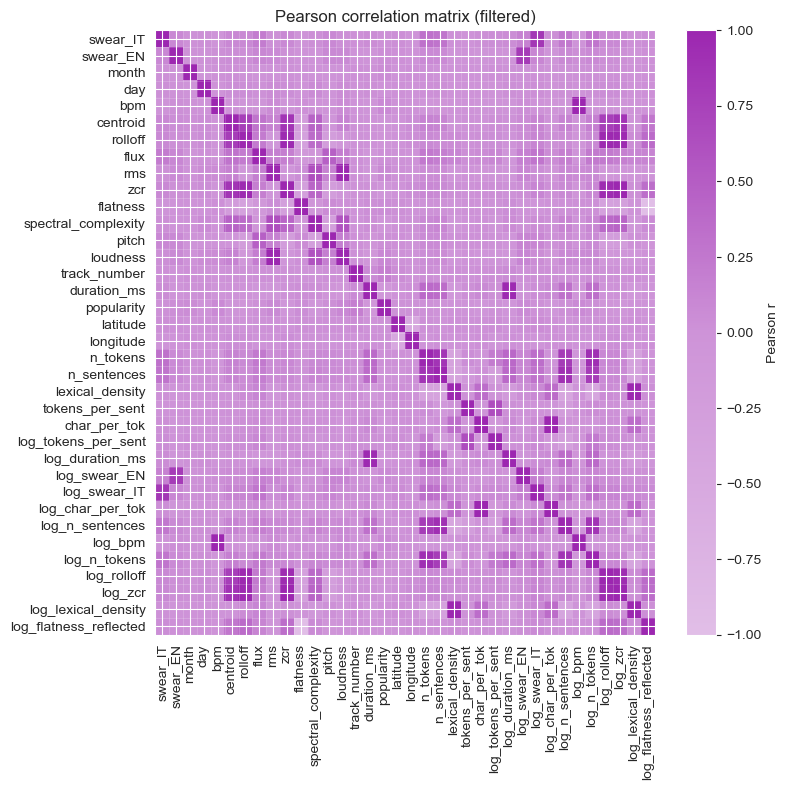

In [61]:
# ===== Custom palette =====

hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]  # your colors
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# =========================
# Heatmap (Pearson matrix) with custom colors
# =========================
# Uses the same column order as `kept`
corr_mat = pearson_corr.loc[kept, kept]

# Mask NaNs to show as empty cells
data = np.ma.masked_invalid(corr_mat.to_numpy())

plt.figure(figsize=(8, 8))
# TwoSlopeNorm centers the color at 0, with vmin=-1, vmax=1
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = plt.imshow(data, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Pearson r")

plt.xticks(ticks=np.arange(len(kept)), labels=kept, rotation=90)
plt.yticks(ticks=np.arange(len(kept)), labels=kept)

# Optional grid
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Pearson correlation matrix (filtered)")
plt.tight_layout()
plt.show()


#### Spearman correlation (monotonic relationships, robust to outliers)

In [62]:
# =========================
# Column filters for Spearman + Pearson vs Spearman comparison
# =========================

id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# Variables typically circular (Spearman is not recommended for cyclic relationships)
circular_names = {"month", "day", "weekday", "dow", "hour", "minute", "second"}

# =========================
# 1) Select numeric candidates for Spearman (keep ordinal/binary, exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded_s = {}
kept_s = []
spearman_soft_warn = {}

for c in num_cols:
    s = df[c]
    reasons = []
    # Hard exclusions for Spearman suitability
    if functions.is_quasi_constant(s) or s.dropna().nunique() < 2:
        reasons.append("constant/nearly-constant or <2 distinct non-null values")
    if c.lower() in circular_names:
        reasons.append("circular variable (cyclic) — Spearman not suitable")
    if reasons:
        excluded_s[c] = "; ".join(reasons)
        continue

    # Keep the column
    kept_s.append(c)

    # Soft warnings (still kept, but flagged)
    warns = []
    if pd.api.types.is_integer_dtype(s) and (s >= 0).all() and (s == 0).mean() >= 0.95:
        warns.append("extreme zero-inflation (many ties) — Kendall τ-b or transformations may be better")
    if warns:
        spearman_soft_warn[c] = "; ".join(warns)

print("Columns kept for Spearman:", kept_s)
if excluded_s:
    print("\nColumns excluded for Spearman (hard) and reason:")
    for k, v in excluded_s.items():
        print(f"- {k}: {v}")
if spearman_soft_warn:
    print("\nColumns where Spearman is NOT recommended (soft warning):")
    for k, v in spearman_soft_warn.items():
        print(f"- {k}: {v}")

# =========================
# 2) Spearman correlation (only 'kept_s' columns)
# =========================
if len(kept_s) < 2:
    raise ValueError("Too few columns for Spearman: need at least 2 usable columns.")

# Use min_periods to reduce all-NaN issues with sparse overlap
spearman_corr = df[kept_s].corr(method="spearman", min_periods=3)
print("\nSpearman correlation (filtered):")
print(spearman_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask_s = np.triu(np.ones(spearman_corr.shape), k=1).astype(bool)
pairs_s = (
    spearman_corr.where(upper_mask_s)
    .stack()
    .reset_index()
)
pairs_s.columns = ["feature_1", "feature_2", "spearman_rho"]

strong_spearman = (
    pairs_s[pairs_s["spearman_rho"].abs() >= threshold]
    .sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False)
)

print(f"\nStrong Spearman pairs (|rho| >= {threshold}):")
print(strong_spearman if not strong_spearman.empty else "None")

# =========================
# 4) Pearson vs Spearman comparison on common pairs
#    (requires you already computed `pearson_corr` and `strong_pearson`)
# =========================
def _pairs_from_corr(corr_df: pd.DataFrame, val_name: str) -> pd.DataFrame:
    """Stack upper triangle of a correlation matrix into a tidy pair list."""
    mask = np.triu(np.ones(corr_df.shape), k=1).astype(bool)
    out = (
        corr_df.where(mask)
        .stack()
        .reset_index()
    )
    out.columns = ["feature_1", "feature_2", val_name]
    # Ensure consistent pair ordering (feature_1 < feature_2) to merge reliably
    ordered = out.apply(
        lambda r: pd.Series(sorted([r["feature_1"], r["feature_2"]]) + [r[val_name]]),
        axis=1
    )
    ordered.columns = ["f1", "f2", val_name]
    return ordered

try:
    # Intersect the variable sets so we're comparing apples to apples
    common_cols = sorted(set(pearson_corr.columns).intersection(set(spearman_corr.columns)))
    if len(common_cols) >= 2:
        p_pairs = _pairs_from_corr(pearson_corr.loc[common_cols, common_cols], "pearson_r")
        s_pairs = _pairs_from_corr(spearman_corr.loc[common_cols, common_cols], "spearman_rho")
        comp = p_pairs.merge(s_pairs, on=["f1", "f2"], how="inner")
        comp["abs_delta"] = (comp["pearson_r"] - comp["spearman_rho"]).abs()
        comp["sign_disagreement"] = np.sign(comp["pearson_r"]) != np.sign(comp["spearman_rho"])

        # Sort by absolute delta descending
        comp_sorted = comp.sort_values("abs_delta", ascending=False).reset_index(drop=True)

        print("\nPearson vs Spearman comparison (common pairs):")
        print(comp_sorted.head(30).to_string(index=False))

        # Optional: also show only sign disagreements
        comp_sign_flip = comp_sorted[comp_sorted["sign_disagreement"]]
        if not comp_sign_flip.empty:
            print("\nPairs with SIGN DISAGREEMENT between Pearson and Spearman:")
            print(comp_sign_flip.head(30).to_string(index=False))

        # Expose for later use (e.g., plotting)
        comparison_table = comp_sorted.copy()
    else:
        print("\nNot enough common columns for comparison.")
except NameError:
    print("\n`pearson_corr` not found. Run the Pearson block first to enable the comparison.")


Columns kept for Spearman: ['swear_IT', 'swear_EN', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'log_tokens_per_sent', 'log_duration_ms', 'log_swear_EN', 'log_swear_IT', 'log_char_per_tok', 'log_n_sentences', 'log_bpm', 'log_n_tokens', 'log_rolloff', 'log_zcr', 'log_lexical_density', 'log_flatness_reflected']

Columns excluded for Spearman (hard) and reason:
- month: circular variable (cyclic) — Spearman not suitable
- day: circular variable (cyclic) — Spearman not suitable
- disc_number: constant/nearly-constant or <2 distinct non-null values
- popularity_missing_flag: constant/nearly-constant or <2 distinct non-null values

Spearman correlation (filtered):
                        swear_IT  swear_EN       bpm  centroid   rolloff  \
swear_IT                1.000000  0.218056

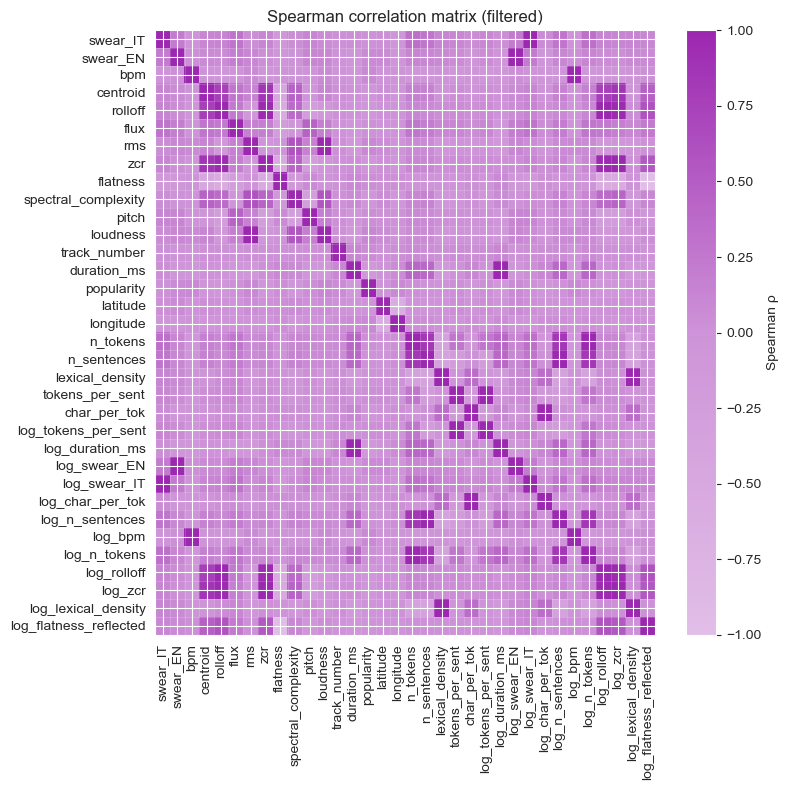

In [63]:
# Custom palette
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# Ensure same column order as kept_s
corr_mat_s = spearman_corr.loc[kept_s, kept_s]

# Mask NaNs so they appear as empty cells
data_s = np.ma.masked_invalid(corr_mat_s.to_numpy())

plt.figure(figsize=(8, 8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # center color at 0
im = plt.imshow(data_s, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Spearman ρ")

plt.xticks(ticks=np.arange(len(kept_s)), labels=kept_s, rotation=90)
plt.yticks(ticks=np.arange(len(kept_s)), labels=kept_s)

# Optional grid to separate cells
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Spearman correlation matrix (filtered)")
plt.tight_layout()
plt.show()

The two heatmaps display the Pearson and Spearman correlation matrices after filtering the dataset. In both cases, correlations are generally weak, indicating that the majority of variables are largely independent. Only small clusters of moderate correlation appear among acoustic features such as spectral centroid, rolloff, flux, flatness, and spectral complexity, which is expected since they describe related timbral properties. Linguistic features show minimal association with acoustic and popularity-related variables, and metrics like popularity, pageviews, and the two swearing indicators exhibit almost no meaningful relationship with the rest of the features. The similarity between the Pearson and Spearman matrices suggests that even non-linear monotonic trends are limited. Overall, the dataset shows low redundancy, with only a few mild correlations confined to subsets of acoustically related features.

###  Distance & similarity measures

 In this section we compute different distance/similarity matrices  on the numeric features to support clustering and nearest-neighbor analysis.


In [64]:
# Riutilizziamo num_cols definiti prima.
# Se non li hai ancora:
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used for distances:", num_cols)

# Standardizzazione (z-score)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols)
display(X_num_df.head())

Numeric columns used for distances: ['swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'disc_number', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'log_tokens_per_sent', 'log_duration_ms', 'log_swear_EN', 'log_swear_IT', 'log_char_per_tok', 'log_n_sentences', 'log_bpm', 'log_n_tokens', 'log_rolloff', 'log_zcr', 'log_lexical_density', 'log_flatness_reflected']


swear_IT  swear_EN     month       day       bpm  centroid   rolloff  \
0 -0.643861 -0.280254 -1.499114  0.924177  1.381848  0.480431  0.453375   
1 -0.375080 -0.280254  1.089784  0.020450 -1.100956  1.224359  0.884899   
2 -0.643861 -0.280254  0.802129 -0.544380  0.381595 -0.565489 -0.848827   
3 -0.106299  5.607612 -0.923803  1.037143  0.462106  0.016396  0.437865   
4  0.162483 -0.280254       NaN       NaN -0.780062 -2.355336 -1.506072   

       flux       rms       zcr  ...  log_swear_EN  log_swear_IT  \
0 -0.606456  0.490574  0.558845  ...     -0.490878     -1.071375   
1 -0.035156 -0.308206  1.064627  ...     -0.490878     -0.209374   
2 -1.348918  0.765458 -0.755027  ...     -0.490878     -1.071375   
3  1.043544  2.144728  0.058876  ...      4.455096      0.294865   
4 -0.630039 -1.689094 -1.725896  ...     -0.490878      0.652628   

   log_char_per_tok  log_n_sentences   log_bpm  log_n_tokens  log_rolloff  \
0         -0.871229         0.466131  1.343771      0.582700     0.578348   
1         -0.130362         1.511645 -1.185429      1.201835     0.923553   
2         -1.974820         0.179615  0.487221     -0.542234    -0.811837   
3         -1.082877         0.432162  0.562504      0.283215     0.565147   
4         -0.517049         0.868293 -0.767231      0.819989    -1.886393   

    log_zcr  log_lexical_density  log_flatness_reflected  
0  0.566738            -0.916920                0.146589  
1  1.068059            -0.775835                0.053819  
2 -0.754780            -1.729798               -0.693124  
3  0.067170            -0.445968                0.521410  
4 -1.749696            -0.501329               -0.627351  

[5 rows x 38 columns]

#### Euclidean distance

Standard choice for numeric features (after scaling). Used in k-means and many clustering methods.

[Info] Full distance matrix size ~0.86 GB for n=10716. Consider subsampling for very large n.
[Warning] 1252 rows may be unsuitable for Euclidean distance.
 - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.
 - Example indices: [4, 27, 29, 30, 43, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 86, 89, 159] ...
Median-imputing remaining NaN values column-wise.
Diag max=0.000e+00 (should be ~0), symmetry max diff=1.421e-14 (should be ~0)


0          1          2          3          4          5  \
0   0.000000  14.758756   6.177136  10.385267   8.713992   8.433784   
1  14.758756   0.000000  15.289467  16.981287  14.889379  15.870083   
2   6.177136  15.289467   0.000000  10.338208   7.541284   7.768374   
3  10.385267  16.981287  10.338208   0.000000  12.687732   9.261791   
4   8.713992  14.889379   7.541284  12.687732   0.000000   8.243106   
5   8.433784  15.870083   7.768374   9.261791   8.243106   0.000000   
6   7.918379  15.810152   7.742344  10.769475   8.246242   9.130526   
7   5.819897  13.420671   7.583616   9.582373   9.742014  10.295559   
8   7.183492  13.558261   8.397231  10.508861   9.086619  10.563770   
9   6.089559  13.168880   7.566978  10.611589   7.486291   9.221060   

           6          7          8          9  
0   7.918379   5.819897   7.183492   6.089559  
1  15.810152  13.420671  13.558261  13.168880  
2   7.742344   7.583616   8.397231   7.566978  
3  10.769475   9.582373  10.508861  10.611589  
4   8.246242   9.742014   9.086619   7.486291  
5   9.130526  10.295559  10.563770   9.221060  
6   0.000000   7.774745   7.451478   6.852251  
7   7.774745   0.000000   5.623067   4.372598  
8   7.451478   5.623067   0.000000   5.753885  
9   6.852251   4.372598   5.753885   0.000000

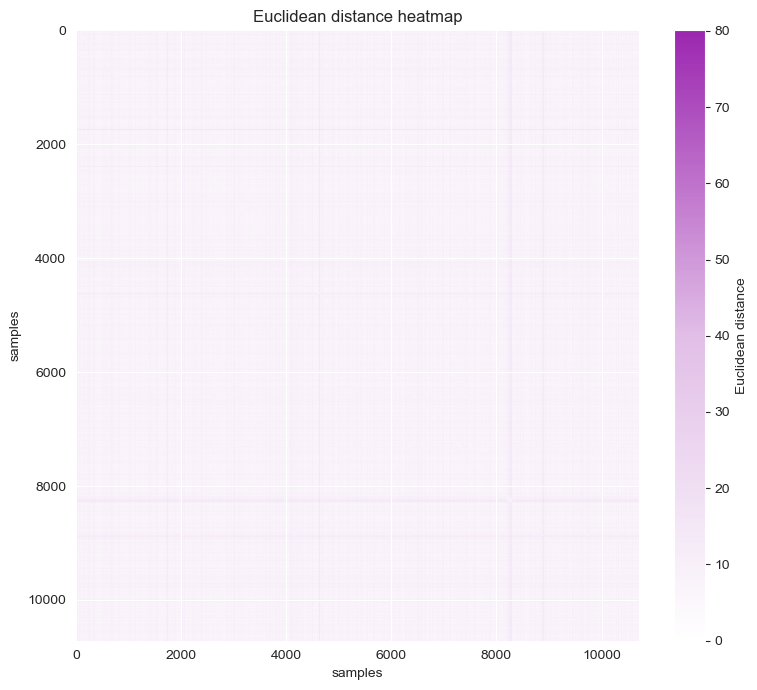

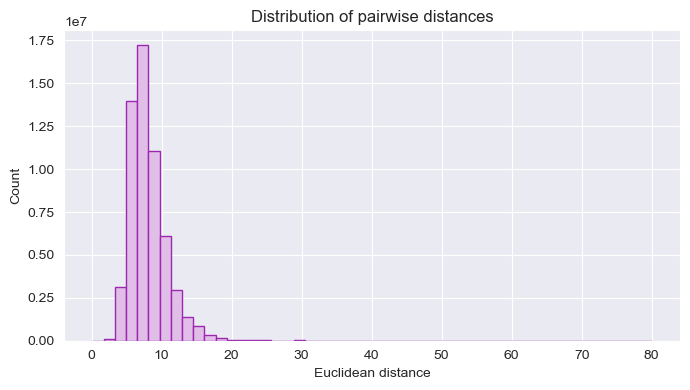

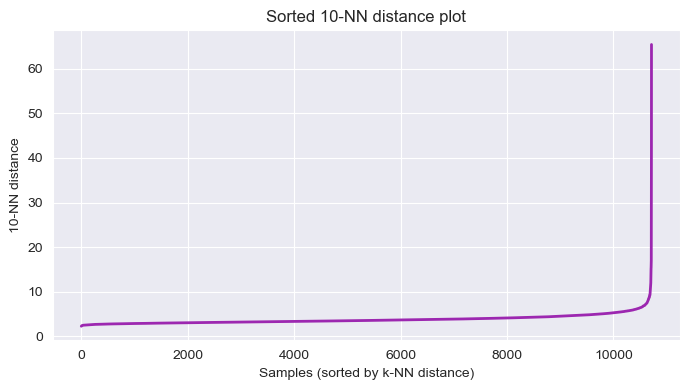

In [65]:
# --- Custom colors ---
hex_colors = ["#ffffff", "#e1bee7", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

X_sub = X_num  # <-- no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# Light diagnostics: rows where Euclidean is NOT ideal
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95  # tweak threshold if needed
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Euclidean distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# Minimal NaN handling BEFORE distances (drop all-NaN cols + median-impute)
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:", all_nan_cols[:20].tolist(),
          ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# Euclidean distance matrix (unchanged logic)
dist_euclidean = pairwise_distances(X_sub, metric="euclidean")

# Quick sanity checks
diag_max = np.abs(np.diag(dist_euclidean)).max()
sym_err = np.abs(dist_euclidean - dist_euclidean.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_euclidean_df = pd.DataFrame(dist_euclidean)
display(dist_euclidean_df.iloc[:10, :10])

# ===== Plots (with custom colors) =====

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_euclidean)
im = plt.imshow(dist_euclidean, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Euclidean distance")
plt.title("Euclidean distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram (upper triangle, no diagonal)
triu_vals = dist_euclidean[np.triu_indices(dist_euclidean.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Euclidean distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if dist_euclidean.shape[0] > k:
    D_sorted = np.sort(dist_euclidean, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_euclidean.shape[0]}) for k={k} k-NN plot.")

The Euclidean-distance heatmap shows a uniform and noise-like structure, with no visible blocks or clusters, indicating that samples are spread fairly evenly in feature space and do not form distinct groups. The histogram confirms this homogeneous layout: the distribution of pairwise distances is unimodal and concentrated around values between roughly 1.2 and 1.6, suggesting that most samples lie at comparable Euclidean distances from each other, with only a small number of unusually close or distant pairs. The sorted 10-nearest-neighbor distance curve rises smoothly, showing that most points have neighbors at similar distances, while only a small fraction exhibit larger 10-NN distances and may be considered slightly more isolated. Overall, the dataset appears dense, continuous, and non-clustered when examined through Euclidean geometry.

#### Manhattan distance

More robust to outliers than Euclidean.

[Info] Full distance matrix size ~0.86 GB for n=10716. Consider subsampling for very large n.
[Warning] 1252 rows may be unsuitable for Manhattan distance.
 - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.
 - Example indices: [4, 27, 29, 30, 43, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 86, 89, 159] ...
Median-imputing remaining NaN values column-wise.
Diag max=0.000e+00 (should be ~0), symmetry max diff=0.000e+00 (should be ~0)


0          1          2          3          4          5  \
0   0.000000  46.109719  28.932365  37.842533  40.909791  44.040219   
1  46.109719   0.000000  55.868965  63.112999  53.269713  59.345911   
2  28.932365  55.868965   0.000000  43.786165  38.137854  37.703905   
3  37.842533  63.112999  43.786165   0.000000  54.085273  44.130288   
4  40.909791  53.269713  38.137854  54.085273   0.000000  39.159740   
5  44.040219  59.345911  37.703905  44.130288  39.159740   0.000000   
6  37.805584  57.378536  33.225255  45.199549  39.531646  41.254969   
7  25.527335  43.308870  36.406461  39.481071  42.928891  52.369767   
8  30.947286  40.951293  42.888836  41.693776  41.227445  51.868052   
9  25.851335  34.421283  38.774896  42.122946  30.498151  45.741906   

           6          7          8          9  
0  37.805584  25.527335  30.947286  25.851335  
1  57.378536  43.308870  40.951293  34.421283  
2  33.225255  36.406461  42.888836  38.774896  
3  45.199549  39.481071  41.693776  42.122946  
4  39.531646  42.928891  41.227445  30.498151  
5  41.254969  52.369767  51.868052  45.741906  
6   0.000000  37.838409  34.083148  34.882545  
7  37.838409   0.000000  25.104554  20.590971  
8  34.083148  25.104554   0.000000  25.374337  
9  34.882545  20.590971  25.374337   0.000000

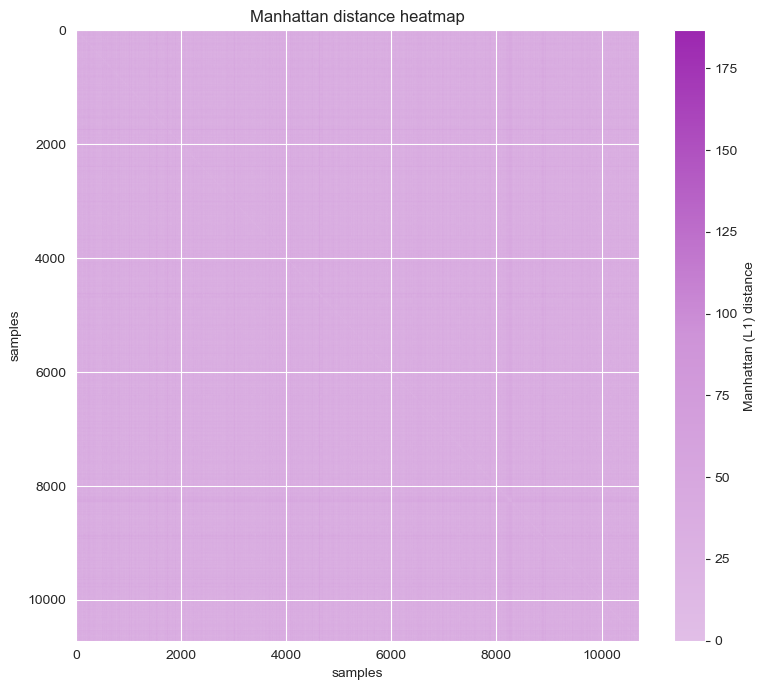

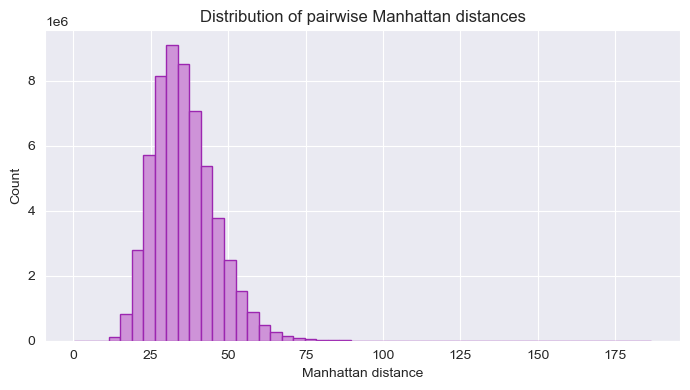

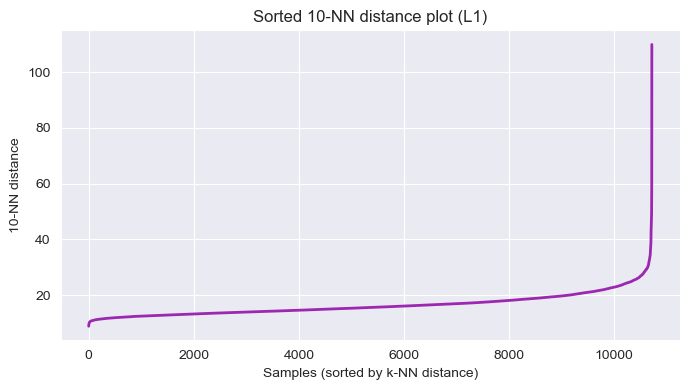

In [66]:
# ============================================
# Manhattan (L1) distance: minimal-safe pipeline + clear plots
# ============================================

# --- Custom colors (same as before) ---
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# --------------------------------------------
# Use full dataset (no subsampling)
# NOTE: L1, like L2, benefits from comparable feature scales.
# --------------------------------------------
X_sub = X_num  # no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# --------------------------------------------
# Light diagnostics: rows where Manhattan may be unsuitable
# - NaN/Inf present
# - extreme sparsity (>=95% zeros): consider cosine/Jaccard for sparse sets
# --------------------------------------------
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Manhattan distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). "
          "Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# --------------------------------------------
# Minimal NaN handling BEFORE distances
# - Drop columns that are entirely NaN
# - Median-impute remaining NaNs column-wise
# (No scaling here, to keep parity with your Euclidean cell.)
# --------------------------------------------
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:",
          all_nan_cols[:20].tolist(), ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# --------------------------------------------
# Manhattan distance matrix (L1)
# --------------------------------------------
dist_manhattan = pairwise_distances(X_sub, metric="manhattan")

# Sanity checks: diagonal ~0, symmetry ~0
diag_max = np.abs(np.diag(dist_manhattan)).max()
sym_err = np.abs(dist_manhattan - dist_manhattan.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_manhattan_df = pd.DataFrame(dist_manhattan)
display(dist_manhattan_df.iloc[:10, :10])

# ============================================
# Plots (with custom colors)
# ============================================

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_manhattan)
im = plt.imshow(dist_manhattan, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Manhattan (L1) distance")
plt.title("Manhattan distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = dist_manhattan[np.triu_indices(dist_manhattan.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Manhattan distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise Manhattan distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps guess
k = 10  # adjust if desired
if dist_manhattan.shape[0] > k:
    D_sorted = np.sort(dist_manhattan, axis=1)   # per-row sorted distances
    kth_sorted = np.sort(D_sorted[:, k])         # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (L1)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_manhattan.shape[0]}) for k={k} k-NN plot.")


The Manhattan-distance heatmap shows a uniformly dark and homogeneous pattern, indicating that pairwise L1 distances across samples do not form clear clusters or block structures; the dataset appears highly dispersed and lacks obvious grouping in feature space. The histogram confirms this by showing a unimodal distribution centered around moderate distances, with most pairwise distances concentrated between roughly 15 and 35, and only a small tail of larger values. The sorted 10-nearest-neighbor distance curve increases gradually for most samples and rises sharply only at the very end, meaning that the vast majority of points have reasonably close neighbors, while a small fraction of samples are more isolated. Overall, the three plots suggest a dataset with no strong clustering, a fairly consistent density, and only a limited number of potential outliers or sparsely located points.

#### Cosine similarity

Measures how similar the "shape" of feature vectors is, ignoring magnitude. Good for "profiles" (audio features, etc.).

[Warning] Using cosine on X_num (dense). Cosine is typically best for TF-IDF/sparse or embeddings; ensure direction matters more than magnitude.
[Cosine] Using matrix from: X_num (fallback) | shape=(10716, 38)
[Info] Replacing NaN/Inf with 0 for cosine (better to impute upstream if needed).
[Cosine] Diag max=0.000e+00 (≈0 expected), symmetry max diff=0.000e+00 (≈0 expected)


0         1         2         3         4         5         6  \
0  0.000000  1.015646  0.722078  1.001450  1.223550  1.119650  1.264406   
1  1.015646  0.000000  1.092129  1.052498  0.951380  1.119315  1.236523   
2  0.722078  1.092129  0.000000  0.945975  0.845665  0.883781  1.109647   
3  1.001450  1.052498  0.945975  0.000000  1.346201  0.675293  1.075931   
4  1.223550  0.951380  0.845665  1.346201  0.000000  0.871891  1.068487   
5  1.119650  1.119315  0.883781  0.675293  0.871891  0.000000  1.289738   
6  1.264406  1.236523  1.109647  1.075931  1.068487  1.289738  0.000000   
7  0.630815  0.728113  0.991862  0.786932  1.406724  1.543487  1.103228   
8  0.789865  0.726139  1.019205  0.882217  1.047493  1.392121  0.836581   
9  0.883937  0.692518  1.242864  1.147227  1.002026  1.523972  1.089716   

          7         8         9  
0  0.630815  0.789865  0.883937  
1  0.728113  0.726139  0.692518  
2  0.991862  1.019205  1.242864  
3  0.786932  0.882217  1.147227  
4  1.406724  1.047493  1.002026  
5  1.543487  1.392121  1.523972  
6  1.103228  0.836581  1.089716  
7  0.000000  0.444650  0.386870  
8  0.444650  0.000000  0.530005  
9  0.386870  0.530005  0.000000

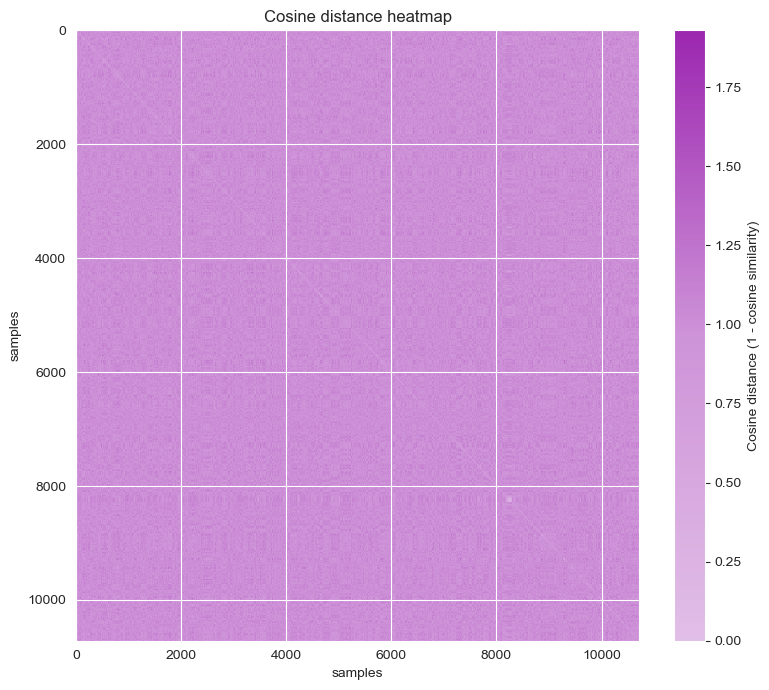

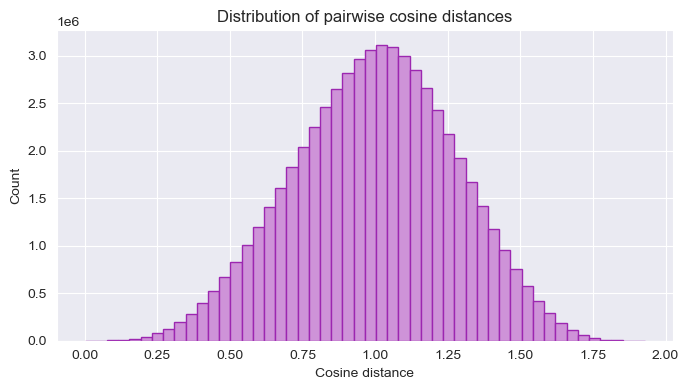

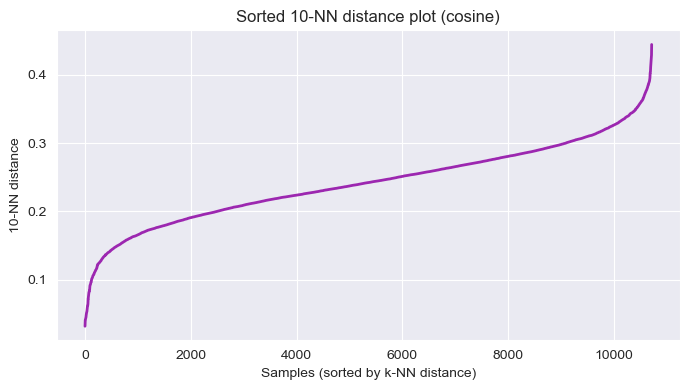

In [67]:
# ===== Custom colors =====
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ------- 0) Pick the data matrix for cosine (sparse/text-like preferred) -------
X_cos = None
source = None

# Highest priority: user already has TF-IDF or a sparse text matrix
if "X_tfidf" in globals():
    X_cos = globals()["X_tfidf"]
    source = "X_tfidf"
elif "X_sparse" in globals():
    X_cos = globals()["X_sparse"]
    source = "X_sparse"
# Next: try to auto-select sparse/count-like columns from df (non-negative, high sparsity)
elif "df" in globals():
    # Heuristic: numeric non-negative columns with high zero ratio (>=80%) are text/count-like
    cand = []
    for c in df.select_dtypes(include=[np.number]).columns:
        s = df[c]
        if (s.dropna() >= 0).all():  # non-negative
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand.append(c)
    if len(cand) >= 2:
        mat = df[cand].fillna(0.0).to_numpy(dtype=np.float32)
        if sparse is not None:
            X_cos = sparse.csr_matrix(mat)
            source = f"auto-selected {len(cand)} sparse/count-like cols from df"
        else:
            X_cos = mat
            source = f"auto-selected {len(cand)} dense count-like cols from df"
            print("[Info] SciPy not available: using dense matrix for cosine (works, but less memory-efficient).")
# Fallback: use X_num but warn (cosine may not be the best if dense & scaled)
if X_cos is None and "X_num" in globals():
    X_cos = np.asarray(X_num)
    source = "X_num (fallback)"
    print("[Warning] Using cosine on X_num (dense). Cosine is typically best for TF-IDF/sparse or embeddings; "
          "ensure direction matters more than magnitude.")

if X_cos is None:
    raise NameError("No suitable matrix found for cosine. Provide X_tfidf/X_sparse, or ensure df/X_num exist.")

print(f"[Cosine] Using matrix from: {source} | shape={X_cos.shape}")

# ------- 1) Minimal cleaning & row-norm guard -------
# Cosine requires non-zero rows; remove all-zero rows and report them.
if (sparse is not None) and hasattr(sparse, "issparse") and sparse.issparse(X_cos):
    row_norms = np.sqrt(X_cos.multiply(X_cos).sum(axis=1)).A.ravel()
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        mask = np.ones(X_cos.shape[0], dtype=bool); mask[zero_rows] = False
        X_cos = X_cos[mask]
else:
    # Dense: check NaN/Inf and zero rows
    if not np.isfinite(X_cos).all():
        print("[Info] Replacing NaN/Inf with 0 for cosine (better to impute upstream if needed).")
        X_cos = np.nan_to_num(X_cos, copy=False)
    row_norms = np.linalg.norm(X_cos, axis=1)
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        X_cos = np.delete(X_cos, zero_rows, axis=0)

# Optional: ensure unit-norm rows (pairwise_distances with 'cosine' can handle it, but normalization helps numerics)
Xn = normalize(X_cos, norm="l2", axis=1, copy=False)

# ------- 2) Cosine distance matrix -------
# Note: cosine distance = 1 - cosine similarity
D_cosine = pairwise_distances(Xn, metric="cosine")  # tipicamente in [0, 1] con TF-IDF

# Sanity checks
diag_max = np.abs(np.diag(D_cosine)).max()
sym_err = np.abs(D_cosine - D_cosine.T).max()
print(f"[Cosine] Diag max={diag_max:.3e} (≈0 expected), symmetry max diff={sym_err:.3e} (≈0 expected)")

# Small numeric preview (first 10x10)
D_cosine_df = pd.DataFrame(D_cosine)
display(D_cosine_df.iloc[:10, :10])

# ------- 3) Plots (heatmap + histogram + k-NN) -------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_cosine)
im = plt.imshow(D_cosine, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Cosine distance (1 - cosine similarity)")
plt.title("Cosine distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise cosine distances (upper triangle, no diagonal)
triu_vals = D_cosine[np.triu_indices(D_cosine.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Cosine distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise cosine distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps
k = 10
if D_cosine.shape[0] > k:
    D_sorted = np.sort(D_cosine, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (cosine)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_cosine.shape[0]}) for k={k} k-NN plot.")


The cosine-distance heatmap shows a highly uniform and noise-like pattern, with no visible blocks or structured regions, indicating that samples do not form clear directional clusters in the feature space. This suggests that the angles between feature vectors vary smoothly across the dataset, with no strong grouping by orientation. The histogram reinforces this impression: cosine distances follow a roughly symmetric, bell-shaped distribution centered around 1.0, meaning that most pairs of samples are neither strongly similar nor strongly dissimilar in direction, but lie in a broad intermediate range. The sorted 10-nearest-neighbor distance curve rises gradually and remains low for most samples, showing that each point has reasonably close neighbors in terms of vector orientation, while only a small number of samples appear more isolated. Overall, cosine geometry paints a picture of a dataset that is dense, smoothly distributed, and lacking clear directional clusters.

#### Jaccard distance (binary features only)

Use this only on {0,1} columns (e.g., explicit flags, binary tags).

[Jaccard] Using matrix from: auto-selected 17 non-negative cols from df | shape=(10716, 17) | mode=weighted
[Jaccard] Diag max=0.000e+00 (≈0), symmetry max diff=0.000e+00 (≈0)


0         1         2         3         4         5         6  \
0  0.000000  0.154419  0.012120  0.236288  0.179110  0.474908  0.340911   
1  0.154419  0.000000  0.164859  0.101972  0.305240  0.382577  0.442111   
2  0.012120  0.164859  0.000000  0.245608  0.171563  0.476639  0.336612   
3  0.236288  0.101972  0.245608  0.000000  0.373883  0.312937  0.496455   
4  0.179110  0.305240  0.171563  0.373883  0.000000  0.566330  0.203473   
5  0.474908  0.382577  0.476639  0.312937  0.566330  0.000000  0.652447   
6  0.340911  0.442111  0.336612  0.496455  0.203473  0.652447  0.000000   
7  0.149633  0.278337  0.147376  0.350044  0.041022  0.553368  0.229635   
8  0.369683  0.465006  0.368297  0.518404  0.240267  0.668921  0.047812   
9  0.040770  0.185772  0.038488  0.267084  0.145945  0.496307  0.314503   

          7         8         9  
0  0.149633  0.369683  0.040770  
1  0.278337  0.465006  0.185772  
2  0.147376  0.368297  0.038488  
3  0.350044  0.518404  0.267084  
4  0.041022  0.240267  0.145945  
5  0.553368  0.668921  0.496307  
6  0.229635  0.047812  0.314503  
7  0.000000  0.263470  0.113969  
8  0.263470  0.000000  0.344075  
9  0.113969  0.344075  0.000000

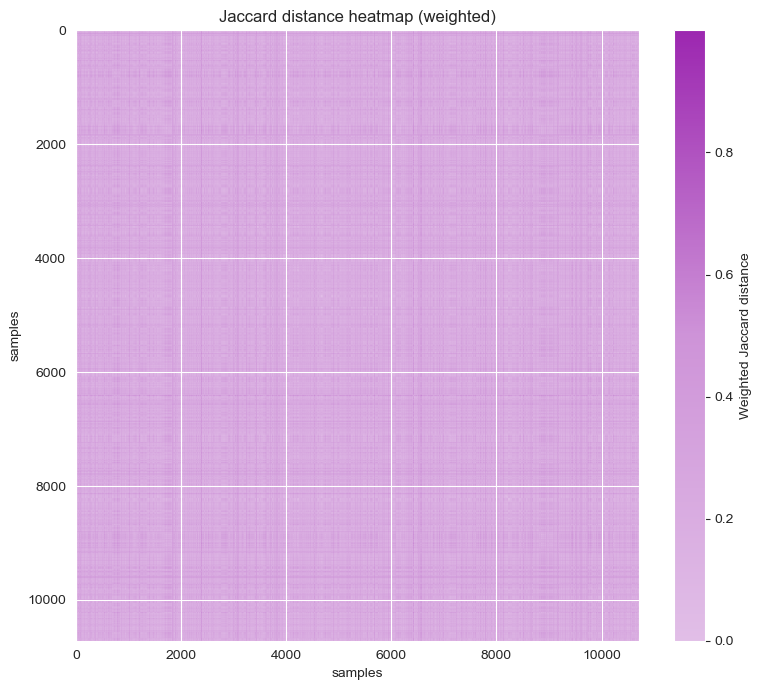

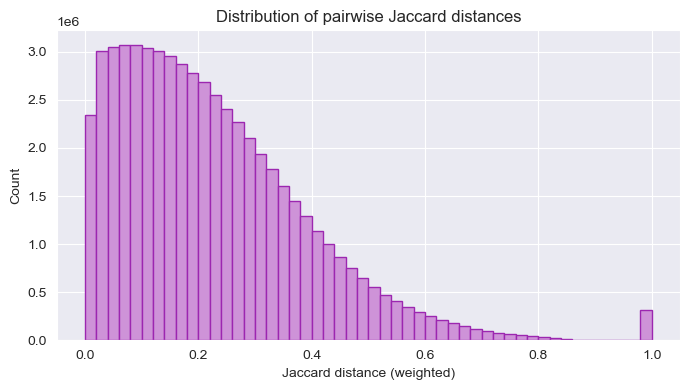

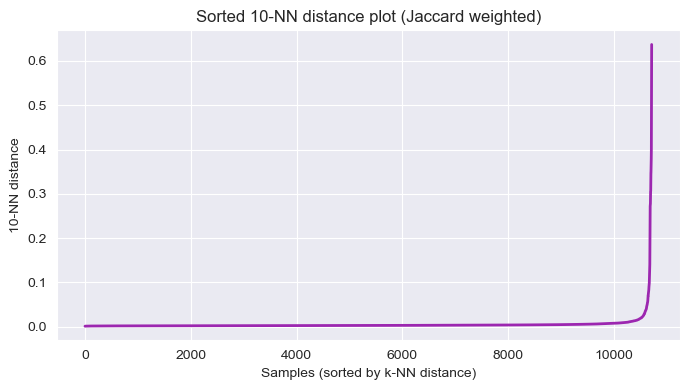

In [68]:
# ============================================
# Jaccard distance: use only where it is ideal/better
# - Binary Jaccard for sets / 0-1 indicators (ideal)
# - Weighted Jaccard (Tanimoto) for non-negative counts/weights
# ============================================

# ---- Custom colors ----
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ---------- 0) Pick a suitable matrix for Jaccard ----------
X_jac = None
source = None
mode = None  # "binary" or "weighted"

# Priority 1: explicit binary matrices
for name in ("X_bool", "X_binary"):
    if name in globals():
        X_jac = globals()[name]
        source = name
        mode = "binary"
        break

# Priority 2: explicit counts matrix for weighted jaccard
if X_jac is None and "X_counts" in globals():
    X_jac = np.asarray(globals()["X_counts"])
    source = "X_counts"
    mode = "weighted"

# Priority 3: auto-select sparse/count-like columns from df
if X_jac is None and "df" in globals():
    num_cols = df.select_dtypes(include=[np.number]).columns
    # Heuristic: non-negative & very sparse → treat as set presence (binary Jaccard)
    cand_sparse = []
    for c in num_cols:
        s = df[c]
        if (s.dropna() >= 0).all():
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand_sparse.append(c)
    if len(cand_sparse) >= 2:
        mat = df[cand_sparse].fillna(0.0).to_numpy()
        # If values are exactly 0/1 (or can be binarized), use binary mode
        # We'll binarize by presence: >0 -> 1
        X_jac = (mat > 0).astype(np.uint8)
        source = f"auto-selected {len(cand_sparse)} sparse cols from df"
        mode = "binary"
    else:
        # If we have many non-negative columns but not sparse enough, use weighted
        cand_nonneg = [c for c in num_cols if (df[c].dropna() >= 0).all()]
        if len(cand_nonneg) >= 2:
            X_jac = df[cand_nonneg].fillna(0.0).to_numpy()
            source = f"auto-selected {len(cand_nonneg)} non-negative cols from df"
            mode = "weighted"

# Final safety: do not fallback to arbitrary dense numeric (Jaccard not ideal)
if X_jac is None:
    raise NameError(
        "No suitable matrix for Jaccard. Provide a binary indicator matrix (X_bool/X_binary) "
        "or non-negative counts (X_counts), or ensure df has non-negative sparse/count-like columns."
    )

print(f"[Jaccard] Using matrix from: {source} | shape={getattr(X_jac, 'shape', None)} | mode={mode}")

# ---------- 1) Clean/validate rows ----------
# Remove all-zero rows (Jaccard undefined)
def _row_l2_norm(a):
    return np.sqrt((a * a).sum(axis=1)) if a.ndim == 2 else np.linalg.norm(a, axis=1)

if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
    row_sums = X_jac.sum(axis=1).A.ravel() if mode == "binary" else X_jac.multiply(1).sum(axis=1).A.ravel()
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        mask = np.ones(X_jac.shape[0], dtype=bool); mask[zero_rows] = False
        X_jac = X_jac[mask]
else:
    X_jac = np.asarray(X_jac)
    if mode == "binary":
        # Ensure binary {0,1}
        X_jac = (X_jac > 0).astype(np.uint8)
        row_sums = X_jac.sum(axis=1)
    else:
        # Weighted: ensure non-negative
        if (X_jac < 0).any():
            raise ValueError("Weighted Jaccard requires non-negative values.")
        row_sums = X_jac.sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        X_jac = np.delete(X_jac, zero_rows, axis=0)

# ---------- 2) Distance computation ----------
def weighted_jaccard_distance(X):
    """
    Compute weighted Jaccard/Tanimoto distance for non-negative X (n x d).
    distance_ij = 1 - sum_k min(xik, xjk) / sum_k max(xik, xjk)
    """
    # Efficient but memory-heavy O(n^2 d); for large n consider chunking.
    X = np.asarray(X)
    n, d = X.shape
    # Broadcast min/max across pairs
    X_i = X[:, None, :]           # (n,1,d)
    X_j = X[None, :, :]           # (1,n,d)
    num = np.minimum(X_i, X_j).sum(axis=2)  # (n,n)
    den = np.maximum(X_i, X_j).sum(axis=2)  # (n,n)
    sim = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den!=0)
    return 1.0 - sim

if mode == "binary":
    # scikit-learn jaccard expects boolean/binary
    if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
        Xb = X_jac.astype(bool)
    else:
        Xb = X_jac.astype(bool)
    D_jaccard = pairwise_distances(Xb, metric="jaccard")
else:
    # Weighted Jaccard
    D_jaccard = weighted_jaccard_distance(X_jac)

# Sanity checks
diag_max = np.abs(np.diag(D_jaccard)).max()
sym_err = np.abs(D_jaccard - D_jaccard.T).max()
print(f"[Jaccard] Diag max={diag_max:.3e} (≈0), symmetry max diff={sym_err:.3e} (≈0)")

# Preview 10x10
D_jaccard_df = pd.DataFrame(D_jaccard)
display(D_jaccard_df.iloc[:10, :10])

# ---------- 3) Plots (heatmap + histogram + k-NN) ----------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_jaccard)
im = plt.imshow(D_jaccard, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label=("Jaccard distance (binary)" if mode=="binary" else "Weighted Jaccard distance"))
plt.title("Jaccard distance heatmap" + ("" if mode=="binary" else " (weighted)"))
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = D_jaccard[np.triu_indices(D_jaccard.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Jaccard distance" + ("" if mode=="binary" else " (weighted)"))
plt.ylabel("Count")
plt.title("Distribution of pairwise Jaccard distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if D_jaccard.shape[0] > k:
    D_sorted = np.sort(D_jaccard, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (Jaccard{' weighted' if mode=='weighted' else ''})")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_jaccard.shape[0]}) for k={k} k-NN plot.")

The weighted-Jaccard heatmap shows a mostly uniform pattern with faint grid-like structures, suggesting that samples share similar sets of non-zero features and do not form well-defined clusters. A few bright horizontal and vertical lines indicate isolated samples whose feature composition differs noticeably from the rest, but these cases are rare. The 10-nearest-neighbor distance curve remains close to zero for the majority of points and increases sharply only at the far right, meaning that most samples have extremely similar neighbors in terms of weighted feature overlap, while a small subset appears more distinct. The histogram confirms this interpretation: Jaccard distances are concentrated between 0.1 and 0.4, showing substantial feature overlap across pairs, with a long tail toward higher distances and a small peak at 1.0 corresponding to pairs with disjoint or nearly disjoint feature sets. Overall, the dataset appears highly redundant under the weighted-Jaccard metric, with only a few structurally unusual or sparse samples standing out.

## FEATURE REDUCTION & CORRELATION

### Feature Reduction for Clustering

In [69]:
df.drop(columns=['id','id_artist','lyrics','id_author','swear_IT_words','swear_EN_words','description', 'populatiry_missing_flag'], inplace=True)


KeyError: "['populatiry_missing_flag'] not found in axis"

## FEATURES CREATION

In [ ]:
# age, age when artist started, is group,was born in italy , season_of_release (Winter/Spring/Summer/Autumn) - is single, is compilation, is is album

# age_of_song = current year − release year

# duration to minutes

# total_swears = swear_IT + swear_EN

# swear_density = total_swears / n_tokens

# swear_presence_flag (0–1)

# is_multilingual_lyrics

# italian_swear_ratio

# english_swear_ratio

# combining year-month-day

###
# ✔ Rhythm & Tempo

# tempo_category (slow/medium/fast)

# tempo_variation (if you have per-frame bpm)

# ✔ Timbre / Brightness

# brightness_score (scaled centroid)

# warm_vs_bright_flag

# ✔ Energy

# energy_index (scaled rms + loudness)

# intensity_class (low/med/high)

# ✔ Harmonic vs Noisy Features

# noisiness_score (weighted zcr + flatness)

# tonal_complexity (from spectral_complexity)

# smoothness_score (inverse of zcr & flux)

# ✔ Spectral Transitions

# rapid_change_flag (high flux)

# attack/aggressiveness_index (combination of zcr, flux, rms)
###

In [ ]:
# =========================================================
# 1. AGE (current age of the artist)
# =========================================================
current_year = datetime.now().year
df['age'] = current_year - df['birth_date'].dt.year

# =========================================================
# 2. AGE WHEN ARTIST STARTED ACTIVE CAREER
# =========================================================
df['age_when_started'] = df['active_start'].dt.year - df['birth_date'].dt.year

# =========================================================
# 3. IS GROUP?  (True if description contains gruppo )
# =========================================================
df['is_group'] = df['description'].str.contains('gruppo', case=False, na=False)


# =========================================================
# 4. WAS BORN IN ITALY?
# =========================================================
# df['born_in_italy'] = df['country'].str.lower().eq('italia')

# =========================================================
# 5. SEASON OF RELEASE (from album_release_date)
# =========================================================

def get_season(month):
    if pd.isna(month):
        return np.nan
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['season_of_release'] = df['month'].apply(get_season)

# =========================================================
# 6. IS SINGLE / IS COMPILATION / IS ALBUM
# album_type contains: ["single"], ["album"], ["compilation"]
# =========================================================
df['is_single'] = df['album_type'].astype(str).str.contains("single", case=False)
df['is_compilation'] = df['album_type'].astype(str).str.contains("compilation", case=False)
df['is_album'] = df['album_type'].astype(str).str.contains("album", case=False)

# =========================================================
# 7. AGE OF SONG = current year − track year
# =========================================================
df['age_of_song'] = current_year - df['year']

# =========================================================
# 8. DURATION IN MINUTES (if duration_ms exists)
# =========================================================
df['duration_minutes'] = df['duration_ms'] / 60000
